In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

from docplex.mp.model import Model
# from NPG_CMDP import CMDP_NPG
# from ARNPG_CMDP import CMDP_ARNPG

"""Our code customizes the CMDP code from the paper:
Natural Policy Gradient Primal-Dual Method for Constrained Markov Decision Processes, Dongsheng Ding et al.
"""

"""Natural Policy Gradient Primal-Dual Method with Softmax Parametrization
"""
from MARL import MARL_agent, MO_MARL
# Random Seed
np.random.seed(10)


In [2]:
from MARL import MARL_agent
n = 2
a = 3
s = 3
gamma = 0.8

A = a**n

# Randomly generated probability transition matrix P((s,a) -> s') in [0,1]^{|S||A| x |S|}
raw_transition = np.random.uniform(0, 1, size=(s * A, s))
prob_transition = raw_transition / raw_transition.sum(axis=1, keepdims=1)
# Random positive rewards

reward = np.random.uniform(0, 1, size=(s * A))
rewards = [reward]
# Random positive utilities
# utility = np.random.uniform(0, 1, size=(s * A))
# Utility constraint offset b
# Start state distribution
rho = np.ones(s) / s
# rewards = [reward]
temp = MARL_agent(rewards, s, a, rho, gamma, n, prob_transition)
temp.tau = 1

100%|██████████| 1000/1000 [00:01<00:00, 828.31it/s]


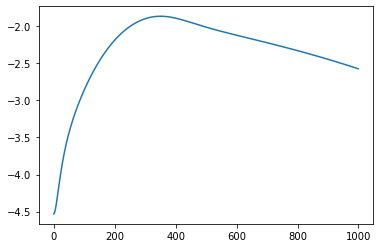

In [3]:
N = 1000
for i in tqdm(range(N)):
    temp.NPG_entropy_step(verbose = False)
#     print(temp.theta)
plt.plot(temp.gap)
# print(temp.gap)
# plt.plot(temp.avg_gap)

-2.5763322002543814


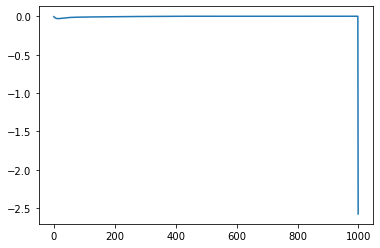

In [4]:
for i in range(0,len(temp.gap)-1):
    temp.gap[i] -= temp.gap[i+1]
plt.plot(temp.gap)
print(np.min(temp.gap))

In [ ]:
N = 500
ax1 = plt.subplot(211)
# ax1.plot(t, np.sin(2*np.pi*t))

ax2 = plt.subplot(212, sharex=ax1)
# ax2.plot(t, np.sin(4*np.pi*t))

for j in range(5):
    temp = MO_MARL(rewards, s, a, rho, gamma, n, prob_transition)
    for i in tqdm(range(N)):
        temp.Centralized_NPG_step(verbose = False)
    ax1.plot(temp.gap)
    ax2.plot(temp.avg_gap)
    
plt.show()
    

 32%|███▏      | 158/500 [00:01<00:02, 140.39it/s]

In [14]:
agent_num = 5
Laplacian = np.zeros((agent_num, agent_num))

for i in range(agent_num):
    Laplacian[i,i] = -2
    Laplacian[i,(i+1)%agent_num] = 1
    Laplacian[i,(i-1)%agent_num] = 1
print(Laplacian)

W = np.zeros((agent_num, agent_num))
eta = 0.1
for i in range(agent_num):
    W[i,i] = 1-2*eta
    W[i,(i+1)%agent_num] = eta
    W[i,(i-1)%agent_num] = eta
print(W)



[[-2.  1.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 1.  0.  0.  1. -2.]]
[[0.8 0.1 0.  0.  0.1]
 [0.1 0.8 0.1 0.  0. ]
 [0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.1 0.8 0.1]
 [0.1 0.  0.  0.1 0.8]]


In [9]:
agent_list = []
for i in range(agent_num):
    agent_list.append(MO_MARL(rewards, s, a, rho, gamma, n, prob_transition))
# for k in range(5):
old_grad = np.zeros((agent_num, reward_num))
grad = np.zeros((agent_num, reward_num))
y = np.zeros((agent_num, reward_num))
all_theta = np.zeros((agent_num, n*s*a))
N = 1000
for k in tqdm(range(N)):
    
    for i in range(agent_num):
        grad[i] = agent_list[i].calculate_G(num=i,verbose = False)
        all_theta[i] = copy.deepcopy(agent_list[i].theta)

    y = W@y+grad-old_grad
#     y = W@grad
#     y = copy.deepcopy(grad)
#     y = y + eta*Laplacian@grad
    old_grad = copy.deepcopy(grad)
    all_theta = W@all_theta
        
    for i in range(agent_num):
        agent_list[i].theta=all_theta[i]
        agent_list[i].NPG_step_given_G(y[i], verbose = False)
        

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


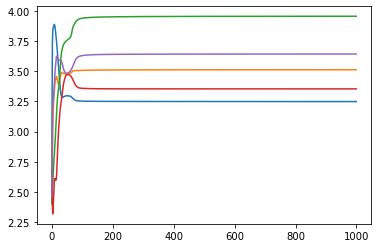

In [10]:
# plt.plot(agent_list[0].Q_record)
plt.plot(agent_list[0].V_record[0])
plt.plot(agent_list[0].V_record[1])
plt.plot(agent_list[0].V_record[2])
plt.plot(agent_list[0].V_record[3])
plt.plot(agent_list[0].V_record[4])

6.313887881586048
6.266685230417442
6.30454248226258
6.367220519322908
6.312252667057926


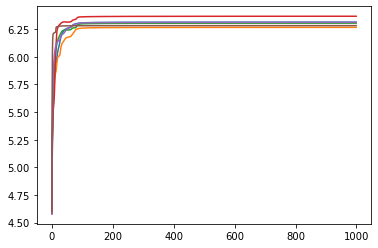

In [13]:
# plt.plot(agent_list[0].gap)

for i in range(agent_num):
    plt.plot(agent_list[i].gap)
    print(agent_list[i].gap[-1])
plt.plot(temp.gap)